In [1]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
import lightgbm # Example model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report

import joblib


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Load dataset from Google Drive
drive_path = '/content/drive/MyDrive/IDS data sets/'
train_file_minmax = drive_path + 'NF-BoT-IoT-V2_5000 samples_minmax_normalized_train.csv'
test_file_minmax = drive_path + 'NF-BoT-IoT-V2_5000 samples_minmax_normalized_test.csv'

train_data = pd.read_csv(train_file_minmax)
test_data = pd.read_csv(test_file_minmax)

Mounted at /content/drive


In [3]:
X_train = train_data.drop(columns=['Attack','FTP_COMMAND_RET_CODE'])
y_train = train_data['Attack']

In [4]:
X_test = test_data.drop(columns=['Attack','FTP_COMMAND_RET_CODE'])
y_test = test_data['Attack']

In [5]:
# Display the number of NaN values per column in X_train and X_test
print("NaN values in each column of X_train:")
print(X_train.isna().sum())

print("\nNaN values in each column of X_test:")
print(X_test.isna().sum())

# Drop columns with any NaN values from X_train and X_test
X_train = X_train.dropna(axis=1)
X_test = X_test.dropna(axis=1)

NaN values in each column of X_train:
L4_SRC_PORT                       0
L4_DST_PORT                       0
PROTOCOL                          0
L7_PROTO                          0
IN_BYTES                          0
IN_PKTS                           0
OUT_BYTES                         0
OUT_PKTS                          0
TCP_FLAGS                         0
CLIENT_TCP_FLAGS                  0
SERVER_TCP_FLAGS                  0
FLOW_DURATION_MILLISECONDS        0
DURATION_IN                       0
DURATION_OUT                      0
MIN_TTL                           0
MAX_TTL                           0
LONGEST_FLOW_PKT                  0
SHORTEST_FLOW_PKT                 0
MIN_IP_PKT_LEN                    0
MAX_IP_PKT_LEN                    0
SRC_TO_DST_SECOND_BYTES           0
DST_TO_SRC_SECOND_BYTES           0
RETRANSMITTED_IN_BYTES            0
RETRANSMITTED_IN_PKTS             0
RETRANSMITTED_OUT_BYTES           0
RETRANSMITTED_OUT_PKTS            0
SRC_TO_DST_AVG_THROUGHPUT 

Attack
DDoS              1904
DoS               1771
Reconnaissance     303
Benign              21
Theft                1
Name: count, dtype: int64


<Axes: xlabel='Attack', ylabel='count'>

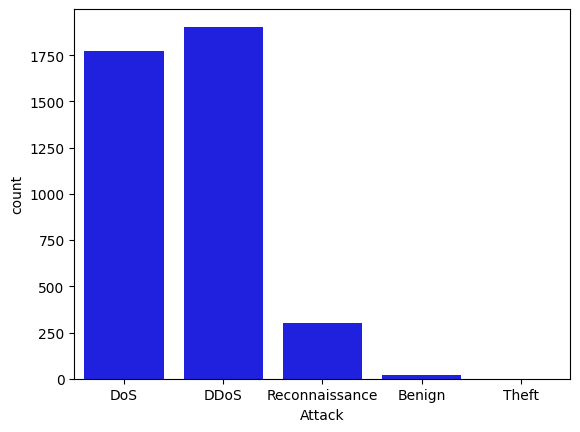

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
X = train_data.drop(['Attack'],axis= 1 )
y = train_data.loc[:, 'Attack']
print( train_data.loc[:, 'Attack'].value_counts())

sns.countplot(data=train_data,x='Attack',color='blue')

In [7]:


def GrdSrch_Tune(model, X, y, params):

    clf = GridSearchCV(model, params, scoring ='recall_weighted', cv = 5, n_jobs=-1)
    clf.fit(X, y)

    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is{} :" .format(clf.best_params_))

    return (clf.best_score_)


In [8]:
params_lgbm = {
    'boosting_type': ['gbdt', 'dart'],         # Reduced to 2 effective options
    'num_leaves': [15, 31],                    # A couple of typical values
    'learning_rate': [0.05, 0.1],              # Moderate learning rates
    'n_estimators': [50, 100],                 # Two values to limit the search time
    'class_weight': ['balanced'],              # Balanced for uneven class distribution
    'colsample_bytree': [0.8],                 # A single, typical value
    'reg_alpha': [0.1],                        # Regularization parameter
    'reg_lambda': [0.1],                       # Regularization parameter
    'n_jobs': [-1]                             # Utilize all processors
}
lgbm_best = GrdSrch_Tune(lightgbm.LGBMClassifier(random_state=42),X_train,y_train,params_lgbm)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 32
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [9]:
from lightgbm import early_stopping


lgbm_model = lightgbm.LGBMClassifier(boosting_type= 'gbdt',class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, n_jobs=-1, random_state=42, reg_alpha=0.1,
               reg_lambda=0.1 ,verbose=-1 ) # Suppress model output

lgbm_model.fit(X_train, y_train, eval_set=(X_test, y_test),
               callbacks=[early_stopping(stopping_rounds=10, verbose=-1)],  # Stops if validation performance doesn’t improve for 10 rounds
              eval_metric="multi_logloss")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.0985607


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, n_jobs=-1, random_state=42, reg_alpha=0.1,
               reg_lambda=0.1, verbose=-1)

In [10]:
y_pred_lgbm = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration_)

In [11]:
rep_lgbm= classification_report(y_test,y_pred_lgbm)
print(rep_lgbm)

                precision    recall  f1-score   support

        Benign       1.00      0.83      0.91         6
          DDoS       0.99      0.99      0.99       484
           DoS       0.98      0.98      0.98       436
Reconnaissance       0.95      0.97      0.96        75

      accuracy                           0.98      1001
     macro avg       0.98      0.94      0.96      1001
  weighted avg       0.98      0.98      0.98      1001



Text(0.5, 1.0, 'Confusion Matrix')

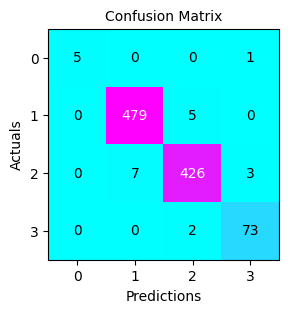

In [12]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
conf_lgbm= confusion_matrix(y_test,y_pred_lgbm)
fig, ax = plot_confusion_matrix(conf_mat=conf_lgbm,figsize=(3,3), cmap=plt.cm.cool)

plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)

In [13]:
#import numpy as np
from sklearn.model_selection import cross_val_score
score_lgbm  = cross_val_score(lgbm_model ,X_train,y_train,cv=10,scoring='recall_weighted')
avg_scores_lgbm  = score_lgbm.mean()

scores_lgbm_test = cross_val_score(lgbm_model, X_test, y_test ,cv = 10, scoring = 'recall_weighted')
avg_scores_lgbm_test = scores_lgbm_test.mean()

print("Train score is:",format(avg_scores_lgbm))
print("Test score is:",format(avg_scores_lgbm_test))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Train score is: 0.98675
Test score is: 0.9790198019801981


In [14]:
model_path = '/content/drive/MyDrive/IDS data sets/lightGBM_classifier.joblib'
joblib.dump(lgbm_model, model_path)

['/content/drive/MyDrive/IDS data sets/lightGBM_classifier.joblib']

In [15]:
X_train.shape[1]

39

In [16]:
X_test.shape[1]

39